V tomto příkladu budeme pracovat s Bibliografií českého literárního exilu, která obsahuje záznamy o knihách a statích s literární tématikou, vydaných a publikovaných v českých exilových nakladatelstvích a časopisech. Nás budou zajímat pouze záznamy o statích, u kterých jsou uvedeny časopis a místo vydání. Ty najdeme v poli 773 $t. Ukážeme si, jak z dat získat a upravit místo vydání záznamu, zjistit jeho souřadnice a následně místo zobrazit na mapě.

### Načtení dat

Nejprve načteme naše uložená csv data. Jak převést marcovou databázi do csv tabulky a pak csv tabulku načíst jsme si ukázali v předchozím příkladu. Csv tabulku z markové databáze lze vygenerovat i pomocí skriptu save_csv.py.

In [96]:
%pip install pandas 
import pandas as pd

path_to_data = 'data/csv/out_cle.csv'

# Cesta k nasim datum
csv_data = path_to_data

# Nacteni dat
df = pd.read_csv(csv_data, delimiter=',')

# Odstraneni zbytecneho sloupce
df = df.drop(['Unnamed: 0'], axis = 1)

for column in df.columns:
    if df[column].dtype != 'int64':   
        # Hodnoty spojene v jeden string zpatky rozdelime do listu, aby se nam s nim lepe pracovalo
        df[column] = df[column].apply(lambda x: x.split(';') if isinstance(x, str)  else [])



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


Abychom nemuseli psát stejný kód několikrát, napíšeme ho jednou do funkce, kterou pak jednoduše zavoláme. V tomto případě si napíšeme funkci, která nám z několika listů (seznamů) vnořených do sebe vytvoří jeden. To se nám bude hodit, až budeme chtít spočítat četnost výskytů míst vydání. 

In [97]:
# Funkce na "zplosteni" listu -> ze sloupce DataFramu vytvori jeden list se vsemi elementy 
def flatten_list(strings):
    flattened_list = []
    if strings is not None: # Zkontrolujeme, jestli element neni None
        for item in strings:
            if isinstance(item, str):  # Pokud je element string, pridame ho do seznamu
                flattened_list.append(item)
            elif isinstance(item, list):  # Rekurzivne zavola sebe
                flattened_list.extend(flatten_list(item))
        return flattened_list

#### Extrahování místa vydání

Naše data se nachází se sloupci 'magazine', kde je uložen časopis, ve kterém záznam vyšel. V závorce je pak místo vydání časopisu. Jak můžeme vidět, místo vydání u některých záznamů není. V tom případě záznamy nezohledníme a vyřadíme. 
Místa vydání jsou napsaná za jménem časopisu v závorkách. Zjistíme je pomocí regulárního výrazu a uložíme do listu. 

In [98]:
%pip install numpy 

import re
import numpy as np

print(df.columns)
print(df['magazine'].head())
print(df['magazine'].tail())

# regex patern, ktery najde substring mezi zavorkami
pattern_cities = r"\((.*?)\)"

# Ulozime mesta do promenne
cities = df['magazine'].apply(lambda x: [re.search(pattern_cities, y).group(1) if re.search(pattern_cities, y) else None for y in x]).tolist().copy()

# Vytvorime zplostely list, ktery i odstrani None hodnoty
cities = flatten_list(cities)

print("\nUnikátní hodnoty:", np.unique(cities))



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Index(['title', 'author', 'author code', 'year', 'figures', 'description',
       'genre', 'magazine'],
      dtype='object')
0    [Spektrum]
1    [Spektrum]
2    [Spektrum]
3    [Spektrum]
4    [Spektrum]
Name: magazine, dtype: object
9607          [Sklizeň (Hamburg)]
9608    [Modrá revue (Rotterdam)]
9609               [Studie (Řím)]
9610          [Sklizeň (Hamburg)]
9611               [Studie (Řím)]
Name: magazine, dtype: object

Unikátní hodnoty: ['Curych' 'Edmonton' 'Hamburg' 'Kolín nad Rýnem' 'Köln-Ehrenfeld' 'London'
 'London, Index on Censorship' 'Londýn' 'Mnichov' 'New York'
 'New York-Paříž' 'Norman, Oklahoma' 'Rotterdam' 'Scheinfeld' 'St. Gallen'
 'Toronto' 'Vídeň' 'Winterthur-Obstladen' 'Wintertuhr-Obstladen'
 'Wuppertal' 'Řím' 'Ženeva-Middlesex-Mnichov']


#### Čistění dat

Z uniktních hodnot vidíme, že některá města tam jsou jak pod svým původím jménem, tak pod svou českou alternativou (London - Londýn, Köln - Kolín nad Rýnem). U některých jsou překlepy (Wintertuhr-Obstladen -> Winterthur-Obstalden), které musíme opravit. U některých je zase měst více (Wintertuhr-Obstladen , Ženeva-Middlesex-Mnichov). V tomto  případě si všechna města uložíme v seznamu.


In [99]:
from collections import Counter
 
# Odstranime Index on Censorship z elementu "London, Index on Censorship" a spojime "London" a "Londýn"
cities = list(map(lambda x: 'Londýn' if 'London' in x else x, cities))

# Odstranime 'Obstladen' z Winterthur
cities = list(map(lambda x: ['Winterthur', 'Obstalden'] if 'Obstladen' in x else x, cities))

# Vytvorime dva elementy z New York-Paříž
cities = list(map(lambda x: ['New York','Paříž'] if 'New York-Paříž' in x else x, cities))

# Vytvorime dva elementy z New York-Paříž
cities = list(map(lambda x: ['Ženeva','Middlesex', 'Mnichov'] if 'Ženeva-Middlesex-Mnichov' in x else x, cities))

# Prepiseme Köln-Ehrenfeld na Kolín nad Rýnem 
cities = list(map(lambda x: 'Kolín nad Rýnem' if 'Köln-Ehrenfeld' in x else x, cities))

# Zplostime seznam
cities = flatten_list(cities)

# Spocteme vyskyty mest
cities_number_of_records = Counter(cities)

print(cities_number_of_records)

# Vytvorime DataFrame 
cities_df = pd.DataFrame.from_dict(cities_number_of_records, orient='index').reset_index()

# Popiseme sloupce
cities_df.columns = ['city', 'number of records']

Counter({'Mnichov': 2197, 'New York': 2090, 'Řím': 1484, 'Paříž': 928, 'Winterthur': 511, 'Obstalden': 511, 'Hamburg': 428, 'Curych': 273, 'Toronto': 196, 'Rotterdam': 185, 'Wuppertal': 135, 'Kolín nad Rýnem': 120, 'Vídeň': 68, 'Londýn': 65, 'St. Gallen': 65, 'Ženeva': 53, 'Middlesex': 53, 'Edmonton': 39, 'Scheinfeld': 36, 'Norman, Oklahoma': 22})


#### Získání souřadnic



In [100]:
%%script echo skipping

import requests

def get_city_coordinates(city):
    api_key = "MY KEY"
    url = f"https://api.opencagedata.com/geocode/v1/json?q={city}&key={api_key}"
    
    response = requests.get(url)
    data = response.json()
    
    if response.status_code == 200:
        if data["total_results"] > 0:
            lat = data["results"][0]["geometry"]["lat"]
            lon = data["results"][0]["geometry"]["lng"]
            return lat, lon
        else:
            print("No results found for the city.")
    else:
        print("Error occurred while fetching data.")

Couldn't find program: 'echo'


In [106]:
%%script echo skipping

cities_df['latitude'] = None
cities_df['longitude'] = None
df.reindex(columns=['city', 'number of records', 'lat', 'lon'], fill_value=0)

unique_cities = set(cities)
coordinates = {}
for city in unique_cities:
    try:
        (latitude, longitude) = get_city_coordinates(city)
        print(f"Coordinates of {city}: Latitude={latitude}, Longitude={longitude}")
        coordinates[city] = (latitude, longitude)
        cities_df.loc[cities_df['city'] == city, 'latitude'] = latitude
        cities_df.loc[cities_df['city'] == city, 'longitude'] = longitude
    except:
        print(f"City {city} not found.")  

df_coordinates = pd.DataFrame.from_dict(coordinates)
df_coordinates.to_csv('data/coordinates.csv')

Couldn't find program: 'echo'


#### Souřadnice

Souřadnice měst načteme ze souboru coordinates.csv, kde je u každého města zeměpisná šířka (latitude) a výška (longitude). Doplňující kód k získání souřadnic je na konci tohoto notebooku. 

In [102]:
# Nacteme souradnice ze souboru
coordinates = pd.read_csv('data/coordinates.csv')

# Tabulku transormujeme 
coordinates = coordinates.T

# Prejmenujeme sloupce
coordinates.columns = ['latitude', 'longitude']

# Jmena mest, ktera byla v indexu pridame do sloupce 'city'. Diky tomu muzeme spojit tabulky dohromady
coordinates['city'] = coordinates.index

# Spojime tabulky dohromady
points_df = pd.merge(cities_df, coordinates)

#### Vykreslení do mapy

Pro vykreslení použijeme knihovnu geopandas a matplotlib.


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement shapely.geometry (from versions: none)
ERROR: No matching distribution found for shapely.geometry

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


c:\Users\Panuskova\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<Figure size 1500x1200 with 0 Axes>

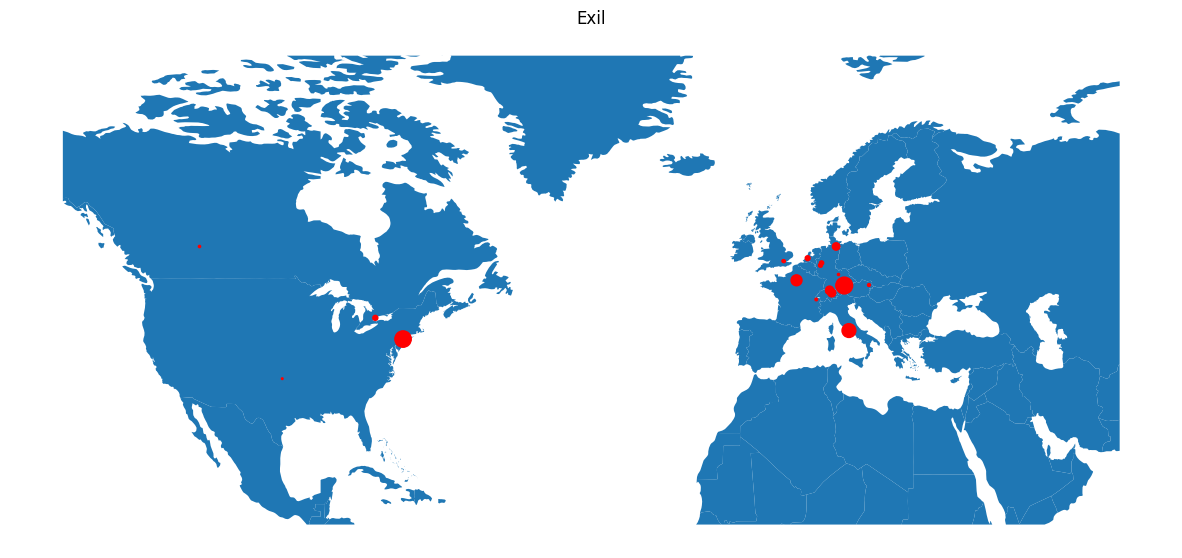

In [103]:
%pip install geopandas
%pip install matplotlib.pyplot
%pip install shapely.geometry

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Ze zemepisne sirky a vysky vytvorime body 
geometry = [Point(lon, lat) for lon, lat in zip(points_df['longitude'], points_df['latitude'])]

# Prevedeme DataFrame na GeoDataFrame
points_gdf = gpd.GeoDataFrame(points_df, geometry=geometry, crs="EPSG:4326") 

base_map_data = gpd.read_file("data/geojson/world_1960.geojson")

# Definujeme hranice Evropy a Severni Ameriky
europe_and_north_america_bbox = [-140, 15, 65, 80]

figsize = (15,12)

plt.figure(figsize=figsize)

# Ohranicime mapu podle europe_and_north_america_bbox
ax = base_map_data.clip(europe_and_north_america_bbox).plot(figsize=figsize)

# Vykresleni
points_gdf.plot(figsize=figsize,ax=ax, color = "red",column='number of records', markersize=points_gdf['number of records'].apply(lambda x: x/15))

plt.title("Exil")
plt.grid(False)
ax.set_axis_off()  
plt.savefig("plots/exil_cropped_map.png")
plt.show()

#### Alternativní vykreslení

In [104]:
%%script echo skipping

%pip install altair
%pip install vl-convert-python
%pip install altair_saver



import altair as alt
alt.data_transformers.disable_max_rows()

url = "https://raw.githubusercontent.com/deldersveld/topojson/master/world-continents.json"
source = alt.topo_feature(url, "continent")


base = alt.Chart(source).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project(
    type = 'mercator',
#    scale= 350,                          # Magnify
#    center= [20,50],                     # [lon, lat]
#    clipExtent= [[0, 0], [400, 300]],    # [[left, top], [right, bottom]]
).properties(
    width=800,
    height=600
)

points = alt.Chart(df).mark_circle().encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size=alt.Size('number of records:Q', title='pocet clanku'),
    tooltip='city:N',
    color=alt.value('red')
)
base+points
combined_chart = base+points
combined_chart.save('plots/map.png')


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
UsageError: Line magic function `%%script` not found.
